In [2]:
from abc import ABC, abstractmethod
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from typing import List, Tuple

from tqdm import tqdm

import lib  #helper functions


In [3]:
class Temperature:
  """
  Wrapper class for a temperature value, with optional decaying
  """

  def __init__(self, value, decay_per_step=1):
    self.initial_value = value
    self.value = value
    self.decay_per_step = decay_per_step

  def is_decaying(self):
    return self.decay_per_step != 1
  
  def decay(self):
    self.value = self.value * self.decay_per_step


In [4]:
class Agent(ABC):
  def __init__(self, env: gym.Env, temp=Temperature(1), alpha=0.1, gamma=1, num_tilings=8,
               tiles_per_tiling=10):
    self.env = env
    self.temp = temp
    self.alpha = alpha/num_tilings  # learning rate
    self.gamma = gamma  # discount factor
    self.num_tilings = num_tilings
    self.tiles_per_tiling = tiles_per_tiling

    self.tile_coder = lib.TileCoder(self.num_tilings,
                                    self.tiles_per_tiling,
                                    list(zip(env.observation_space.low,
                                             env.observation_space.high)))

    self.thetas = None
    self.reset()

  def z(self, state, action) -> float:
    features = self.tile_coder.encode(state)  # binary vec

    return np.sum(self.thetas[action] * features)

  def select_action(self, state, temp=1) -> int:
    z_values = np.array([self.z(state, a) for a in range(self.env.action_space.n)])
    probabilities = np.exp(z_values / temp) / np.sum(np.exp(z_values / temp))

    action = np.random.choice(self.env.action_space.n, p=probabilities)
    return action

  @abstractmethod
  def update(self, state, action, reward, next_state, next_action, done) -> None:
    pass

  def reset(self):
    # params setup
    self.thetas = np.random.uniform(-0.001, 0.001,
                                    (env.action_space.n, self.tile_coder.total_tiles))


Trajectory = List[Tuple['state_t', 'action_t', 'reward_t']]


class REINFORCE(Agent):
  def __init__(self, env: gym.Env, temp=Temperature(1), alpha=0.1, gamma=1, num_tilings=8,
               tiles_per_tiling=10):

    super().__init__(env,
                     temp=temp,
                     alpha=alpha,
                     gamma=gamma,
                     num_tilings=num_tilings,
                     tiles_per_tiling=tiles_per_tiling)

    self.trajectory: Trajectory = list()

  def update(self, state, action, reward, next_state, next_action, done) -> None:
    if not done:
      self.trajectory.append((state, action, reward))
      return

    G = 0  # Store cumulative return
    for st, at, rt in reversed(self.trajectory):
      G = self.gamma * G + rt  # Update return
      features = self.tile_coder.encode(st)
      
      # Compute gradient ascent update for theta
      grad_ln_pi = features - np.sum(
        [self.thetas[a] * features for a in range(self.env.action_space.n)], axis=0) / self.temp.value
      self.thetas[at] += self.alpha * grad_ln_pi * G

    self.trajectory = []  # Clear trajectory


class ActorCritic(Agent):
  def update(self, state, action, reward, next_state, next_action, done) -> None:
    # Get current estimate and next state estimate
    current_value = self.z(state, action)
    next_value = self.z(next_state, next_action) if not done else 0

    td_err = reward + self.gamma * next_value - current_value

    # Update critic
    features = self.tile_coder.encode(state)
    self.thetas[action] += self.alpha * td_err * features

    # Update actor
    # with softmax policy, derive the gradient with respect to theta
    policy_val = np.sum([np.exp(self.z(state, a)) * self.thetas[a] * features for a in range(self.env.action_space.n)], axis=0) / np.sum([np.exp(self.z(state, a)) for a in range(self.env.action_space.n)])
    grad_ln_pi = features - policy_val
    self.thetas[action] += self.alpha * grad_ln_pi * td_err


In [5]:
def run_experiment(agent, num_runs: int, num_episodes: int):
  performances_across_runs = np.zeros(num_episodes)

  with tqdm(total=num_runs * num_episodes) as pbar:
    for run in range(num_runs):
      agent.reset()
      for episode in range(num_episodes):
        # initialize env 
        reward_throughout_ep = 0
        state, info = agent.env.reset()
        state = np.double(state)
        is_terminal = False
        truncated = False

        while not is_terminal and not truncated:
          action = agent.select_action(state, agent.temp.value)

          next_state, reward, is_terminal, truncated, info = agent.env.step(action)
          next_state = np.double(next_state)

          reward_throughout_ep += reward

          next_action = agent.select_action(next_state)

          agent.update(state,
                       action,
                       reward,
                       next_state,
                       next_action,
                       is_terminal or truncated)

          state, action = next_state, next_action

        agent.temp.decay()
        performances_across_runs[episode] += reward_throughout_ep

        pbar.update(1)

  return performances_across_runs / num_runs

 19%|█▉        | 958/5000 [00:01<00:05, 754.70it/s]/var/folders/dc/dj5v5qzn0wv0fk9r_pmp0mgm0000gn/T/ipykernel_82178/2692694998.py:26: RuntimeWarning: overflow encountered in exp
  probabilities = np.exp(z_values / temp) / np.sum(np.exp(z_values / temp))
/var/folders/dc/dj5v5qzn0wv0fk9r_pmp0mgm0000gn/T/ipykernel_82178/2692694998.py:26: RuntimeWarning: invalid value encountered in divide
  probabilities = np.exp(z_values / temp) / np.sum(np.exp(z_values / temp))
 20%|█▉        | 996/5000 [00:01<00:07, 501.04it/s]


ValueError: probabilities contain NaN

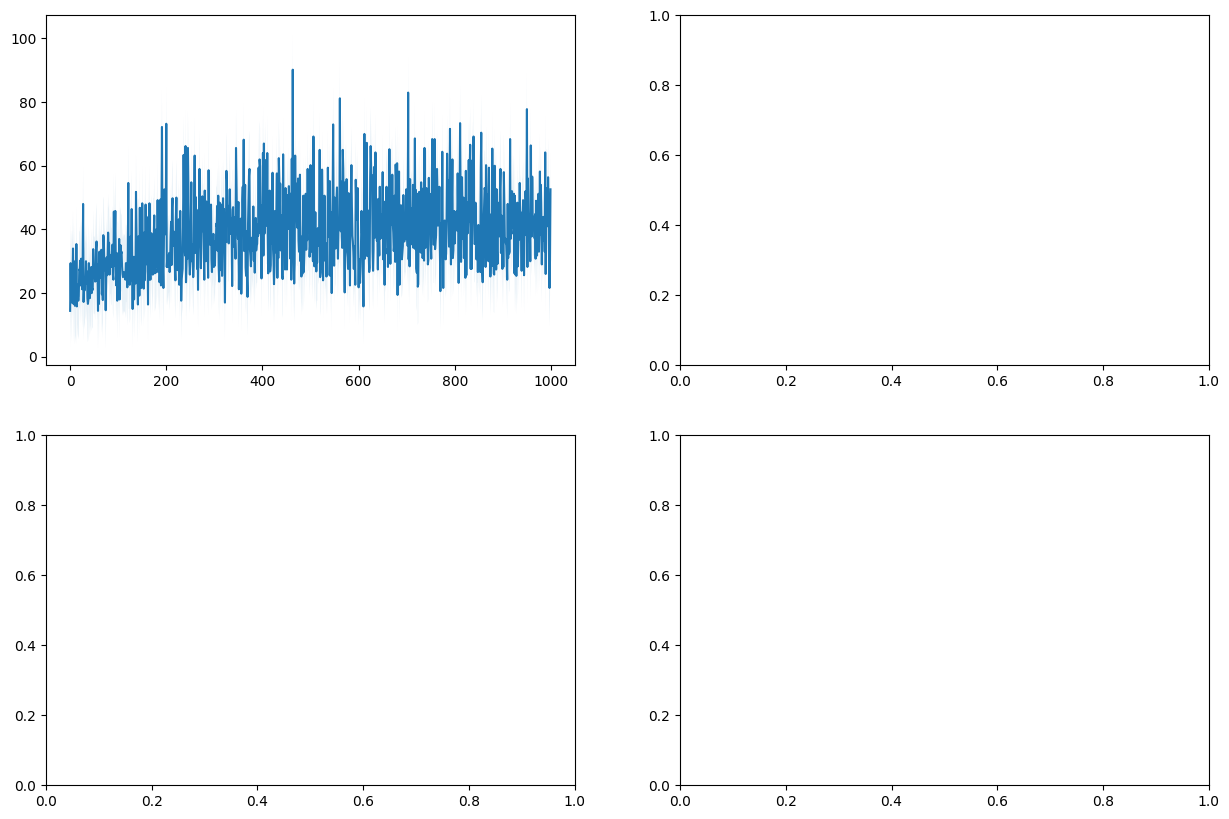

In [8]:
envs = [gym.make('CartPole-v1'), gym.make('MountainCar-v0')]
agents = [REINFORCE, ActorCritic]
temps = [Temperature(1), Temperature(10, decay_per_step=0.99)]

NUM_RUNS = 5
NUM_EPISODES = 1000

alphas = {
  'CartPole-v1': {
    'REINFORCE': 0.0005,
    'ActorCritic': 0.0005
  },
  'MountainCar-v0': {
    'REINFORCE': 0.001,
    'ActorCritic': 0.001
  }
}

gammas = {
  'CartPole-v1': 0.99,
  'MountainCar-v0': 1
}

tilings = {
  'CartPole-v1': {
    'tilings': 4,
    'tiles': 22
  },
  'MountainCar-v0': {
    'tilings': 7,
    'tiles': 14
  }
}

n_envs = len(envs)
n_agents = len(agents)
n_temps = len(temps)

n_plots = n_envs * n_agents * n_temps

fig, axs = plt.subplots(nrows=len(envs), ncols=len(agents), figsize=(15, 10))

if len(envs) * len(agents) > 1:
  axs = axs.flatten()

for agent_idx, agent in enumerate(agents):
  for env_idx, env in enumerate(envs):

    env_name = env.unwrapped.spec.id
    ax = axs[env_idx * len(agents) + agent_idx] if len(envs) * len(agents) > 1 else axs

    for temp in temps:
      exp_agent = agent(env,
                        temp=temp,
                        alpha=alphas[env_name][agent.__name__],
                        gamma=gammas[env_name],
                        num_tilings=tilings[env_name]['tilings'],
                        tiles_per_tiling=tilings[env_name]['tiles'])

      results = run_experiment(exp_agent, NUM_RUNS, NUM_EPISODES)

      if exp_agent.temp.decay == 1:
        label = f'temp={exp_agent.temp}, α={exp_agent.alpha} '
      else:
        label = f'temp={exp_agent.temp} with decay {exp_agent.temp.decay_per_step}^x, α={exp_agent.alpha}'

      ax.plot(results, label=label)

      std_results = np.std(results, axis=0)
      ax.fill_between(range(NUM_EPISODES), results - std_results, results + std_results,
                      alpha=0.1)

  ax.set_title(
    f'{agent.__name__} - {env_name} - {tilings[env_name]["tilings"]} tilings - {tilings[env_name]["tiles"]} tiles'
  )
  ax.set_xlabel('Episodes')
  ax.set_ylabel('Average Return')

  ax.legend()

# Add an overall title and adjust layout
plt.suptitle('Performance of Expected SARSA and Q-Learning with Different ε and α')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()
